In this notebook, Logistic regressions hyperparameters will be tuned on the final feature dataframe. Final model parameters will be chosen based on the one which gives best ROC AUC metric.
First logistic regressions base model will be developed on SMOTE and non SMOTE data. Based on the model performance on these two, final hyperparameters will be tuned on either SMOTE or NON SMOTE data.

## Importing libraries, modules and data

In [ ]:
# Importing the required libraries and modules
import os
import zipfile
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
from tqdm import tqdm

!pip install kds
import kds
from IPython.display import Image

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing the train test oot and train_smote dataframes
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'

#1. X_train dataframe
pickle_in=open(pickle_path+"X_train_final.pickle","rb")
X_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train dataframe is",X_train.shape)

#2. y_train dataframe
pickle_in=open(pickle_path+"y_train_final.pickle","rb")
y_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train dataframe is",y_train.shape)

#3. X_train_smote dataframe
pickle_in=open(pickle_path+"X_train_smote_final.pickle","rb")
X_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train_smote dataframe is",X_train_smote.shape)

#4. y_train_smote dataframe
pickle_in=open(pickle_path+"y_train_smote_final.pickle","rb")
y_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train_smote dataframe is",y_train_smote.shape)

#5. X_test dataframe
pickle_in=open(pickle_path+"X_test_final.pickle","rb")
X_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test dataframe is",X_test.shape)

#6. y_test dataframe
pickle_in=open(pickle_path+"y_test_final.pickle","rb")
y_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_test dataframe is",y_test.shape)

#7. X_oot dataframe
pickle_in=open(pickle_path+"X_oot_final.pickle","rb")
X_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_oot dataframe is",X_oot.shape)

#8. y_oot dataframe
pickle_in=open(pickle_path+"y_oot_final.pickle","rb")
y_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_oot dataframe is",y_oot.shape)

#9. X_test_oot dataframe
pickle_in=open(pickle_path+"X_test_oot_final.pickle","rb")
X_test_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test_oot dataframe is",X_test_oot.shape)

Shape of X_train dataframe is (246008, 15)
Shape of y_train dataframe is (246008,)
Shape of X_train_smote dataframe is (452272, 15)
Shape of y_train_smote dataframe is (452272,)
Shape of X_test dataframe is (30751, 15)
Shape of y_test dataframe is (30751,)
Shape of X_oot dataframe is (30752, 15)
Shape of y_oot dataframe is (30752,)
Shape of X_test_oot dataframe is (48744, 15)


## Model Functions

In [ ]:
def PlotConfusionMatrix(y_test,pred_test):
  cf=metrics.confusion_matrix(y_test,pred_test)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
  group_percentages = ['{0:0.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  labels=[f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(group_names,group_counts,group_percentages)]
  labels=np.asarray(labels).reshape(2,2)

  fig=plt.figure(figsize=(15,5))
  ax=fig.add_subplot(1,2,1)
  sns.heatmap(cf,cmap='crest',linewidth=0.5,annot=labels,fmt='',ax=ax)
  plt.title('Confusion Matrix')
  plt.ylabel('Real Classes')
  plt.xlabel('Predicted Classes')
  plt.show()

  accuracy = np.trace(cf) / float(np. sum(cf))
  precision = cf[1,1] / sum(cf[:,1])
  recall = cf[1,1]/sum(cf[1,:])
  f1_score = 2*precision*recall / (precision + recall)
  print(accuracy)
  print(precision)
  print(recall)
  print(f1_score)

  stats_text = "Accuracy={:0.5f}\nPrecision={:0.5f}\nRecall={:0.5f}\nF1 Score={:0.5F}".format(accuracy,precision,recall,f1_score)
  print("----------------Classification Report----------------")
  print(classification_report(y_test,pred_test))
  print("\n",'----------------Accuracy, precision, recall, f1_score----------------')
  print(stats_text)


In [ ]:
def decile_tablel(act,prob,round_decimal=10,change_deciles=10):
  qq=kds.metrics.decile_table(act,prob
                              ,round_decimal=round_decimal
                              ,change_deciles=change_deciles
                              ,labels=False)[['decile',
                                              'prob_min', 'prob_max',
                                              'cnt_cust', 'cnt_resp',
                                              'cnt_non_resp','cum_non_resp',
                                              'cum_resp', 'KS', 'lift']]
  qq["FP"]=round(qq['cnt_non_resp']/qq['cnt_resp'],2)
  qq["FP_cumm"]=round(qq['cum_non_resp']/qq['cnt_resp'],2)
  qq['prob_min']= round(qq['prob_min'], 6)
  qq['frd_cptr%'] = round(qq['cum_resp']/qq.cnt_resp.sum()*100,2)
  qq.columns = ['decile', 'prob_min', 'prob_max', 'ttl_customers', 'bad_customers','gd_customers', 'cum gd_customers',
                'cum_bad_customers', 'KS', 'Lift', 'FP', 'cum FP', 'default_captr%']
  return qq

In [ ]:
def ROC_curve_combined(actl_train,pred_train,actl_test,pred_test,actl_oot,pred_oot):
  print('Ploting the ROC Curve')
  fpr_train, tpr_train, thresholds =metrics.roc_curve(actl_train, pred_train)
  roc_auc_train = metrics.auc(fpr_train, tpr_train)*100 # compute area under the curve

  fpr_test, tpr_test, thresholds =metrics.roc_curve(actl_test, pred_test)
  roc_auc_test = metrics.auc(fpr_test, tpr_test)*100 # compute area under the curve

  fpr_oot, tpr_oot, thresholds =metrics.roc_curve(actl_oot, pred_oot)
  roc_auc_oot = metrics.auc(fpr_oot, tpr_oot)*100 # compute area under the curve

  plt.figure()
  plt.plot(fpr_train, tpr_train, label='Train ROC curve (area=%0.2f%%)' % (roc_auc_train))
  plt.plot(fpr_test, tpr_test, label='Test ROC curve (area=%0.2f%%)' % (roc_auc_test))
  plt.plot(fpr_oot, tpr_oot, label='OOT ROC curve (area=%0.2f%%)' % (roc_auc_oot))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Bate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc= "lower right")
  plt.show()

## Logistic regression base model on SMOTE data

In [ ]:
# Lets fit the model
lgr_clf = LogisticRegression(random_state=0).fit(X_train_smote, y_train_smote)

In [ ]:
# O=predict the probabilities
lgr_clf_proba_train_smote=lgr_clf.predict_proba(X_train_smote)
lgr_clf_proba_train=lgr_clf.predict_proba(X_train)
lgr_clf_proba_test=lgr_clf.predict_proba(X_test)
lgr_clf_proba_oot=lgr_clf.predict_proba(X_oot)

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,lgr_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,lgr_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,lgr_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,lgr_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.7282081969179311
Train AUC is  0.7200298926341876
Test AUC is  0.7191157023989793
OOT AUC is  0.719539286603046


## Logistic regression base model on NON SMOTE data

In [ ]:
# Lets fit the model
lgr_clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
# O=predict the probabilities
lgr_clf_proba_train_smote=lgr_clf.predict_proba(X_train_smote)
lgr_clf_proba_train=lgr_clf.predict_proba(X_train)
lgr_clf_proba_test=lgr_clf.predict_proba(X_test)
lgr_clf_proba_oot=lgr_clf.predict_proba(X_oot)

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,lgr_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,lgr_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,lgr_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,lgr_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.7259181551332416
Train AUC is  0.7189556585129226
Test AUC is  0.7179024639390357
OOT AUC is  0.7185694185416847


### Observations:
As logistic regressions model ROC AUC metric for SMOTE and NON SMOTE data is similar, lets tune the hyperparameters on SMOTE data.

## Hyperparameter tuning of logistic regression model:

In [ ]:
c_strength=np.logspace(-4,4,10)
solve=['lbfgs','liblinear','newton-cg','sag','saga']
penal=['l2']
cv_dataframe_lgr=pd.DataFrame(columns=['c_strength','solve','penal',
                                       'Train_SMOTE_F1Score','Train_SMOTE_AUC',
                                       'Train_F1Score','Train_AUC',
                                       'Test_F1Score','TEST_AUC',
                                       'OOT_F1Score','OOT_AUC'])

for c_val in tqdm(c_strength):
  for sol_ver in solve:
    for pen in penal:
      df_lst=[c_val,sol_ver,pen]
      print('Evaluating for ',df_lst)
      lgr_clf = LogisticRegression(C=c_val,solver=sol_ver,penalty=pen,random_state=0,max_iter=1000)
      lgr_clf.fit(X_train_smote, y_train_smote)

      # predict the target classes and probabilities
      lgr_clf_predict_train_smote=lgr_clf.predict(X_train_smote)
      lgr_clf_predict_train=lgr_clf.predict(X_train)
      lgr_clf_predict_test=lgr_clf.predict(X_test)
      lgr_clf_predict_oot=lgr_clf.predict(X_oot)

      lgr_clf_proba_train_smote=lgr_clf.predict_proba(X_train_smote)
      lgr_clf_proba_train=lgr_clf.predict_proba(X_train)
      lgr_clf_proba_test=lgr_clf.predict_proba(X_test)
      lgr_clf_proba_oot=lgr_clf.predict_proba(X_oot)

      ### AUC estimation
      # train SMOTE
      f1_sc=f1_score(y_train_smote,lgr_clf_predict_train_smote,average="macro")
      fpr, tpr, threshold = metrics.roc_curve(y_train_smote,lgr_clf_proba_train_smote[:,1])
      roc_auc=metrics.auc(fpr,tpr)
      df_lst.append(f1_sc)
      df_lst.append(roc_auc)

      # train
      f1_sc=f1_score(y_train,lgr_clf_predict_train,average="macro")
      fpr, tpr, threshold = metrics.roc_curve(y_train,lgr_clf_proba_train[:,1])
      roc_auc=metrics.auc(fpr,tpr)
      df_lst.append(f1_sc)
      df_lst.append(roc_auc)

      # test
      f1_sc=f1_score(y_test,lgr_clf_predict_test,average="macro")
      fpr, tpr, threshold = metrics.roc_curve(y_test,lgr_clf_proba_test[:,1])
      roc_auc=metrics.auc(fpr,tpr)
      df_lst.append(f1_sc)
      df_lst.append(roc_auc)

      # oot
      f1_sc=f1_score(y_oot,lgr_clf_predict_oot,average="macro")
      fpr, tpr, threshold = metrics.roc_curve(y_oot,lgr_clf_proba_oot[:,1])
      roc_auc=metrics.auc(fpr,tpr)
      df_lst.append(f1_sc)
      df_lst.append(roc_auc)

      # Lets store in final dataframe
      cv_dataframe_lgr.loc[len(cv_dataframe_lgr)]=df_lst

    # Lets store the dataframes for analysis
    pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
    pickle_out=open(pickle_path+'cv_dataframe_lgr.pickle', 'wb')
    pickle.dump(cv_dataframe_lgr,pickle_out)
    pickle_out.close()
    cv_dataframe_lgr.to_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/cv_dataframe_lgr.csv',index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating for  [0.0001, 'lbfgs', 'l2']
Evaluating for  [0.0001, 'liblinear', 'l2']
Evaluating for  [0.0001, 'newton-cg', 'l2']
Evaluating for  [0.0001, 'sag', 'l2']
Evaluating for  [0.0001, 'saga', 'l2']


 10%|█         | 1/10 [00:26<03:57, 26.37s/it]

Evaluating for  [0.000774263682681127, 'lbfgs', 'l2']
Evaluating for  [0.000774263682681127, 'liblinear', 'l2']
Evaluating for  [0.000774263682681127, 'newton-cg', 'l2']
Evaluating for  [0.000774263682681127, 'sag', 'l2']
Evaluating for  [0.000774263682681127, 'saga', 'l2']


 20%|██        | 2/10 [00:49<03:15, 24.49s/it]

Evaluating for  [0.005994842503189409, 'lbfgs', 'l2']
Evaluating for  [0.005994842503189409, 'liblinear', 'l2']
Evaluating for  [0.005994842503189409, 'newton-cg', 'l2']
Evaluating for  [0.005994842503189409, 'sag', 'l2']
Evaluating for  [0.005994842503189409, 'saga', 'l2']


 30%|███       | 3/10 [01:16<02:58, 25.54s/it]

Evaluating for  [0.046415888336127774, 'lbfgs', 'l2']
Evaluating for  [0.046415888336127774, 'liblinear', 'l2']
Evaluating for  [0.046415888336127774, 'newton-cg', 'l2']
Evaluating for  [0.046415888336127774, 'sag', 'l2']
Evaluating for  [0.046415888336127774, 'saga', 'l2']


 40%|████      | 4/10 [01:46<02:45, 27.56s/it]

Evaluating for  [0.3593813663804626, 'lbfgs', 'l2']
Evaluating for  [0.3593813663804626, 'liblinear', 'l2']
Evaluating for  [0.3593813663804626, 'newton-cg', 'l2']
Evaluating for  [0.3593813663804626, 'sag', 'l2']
Evaluating for  [0.3593813663804626, 'saga', 'l2']


 50%|█████     | 5/10 [10:53<17:54, 214.80s/it]

Evaluating for  [2.782559402207126, 'lbfgs', 'l2']
Evaluating for  [2.782559402207126, 'liblinear', 'l2']
Evaluating for  [2.782559402207126, 'newton-cg', 'l2']
Evaluating for  [2.782559402207126, 'sag', 'l2']
Evaluating for  [2.782559402207126, 'saga', 'l2']


 60%|██████    | 6/10 [17:15<18:06, 271.59s/it]

Evaluating for  [21.54434690031882, 'lbfgs', 'l2']
Evaluating for  [21.54434690031882, 'liblinear', 'l2']
Evaluating for  [21.54434690031882, 'newton-cg', 'l2']
Evaluating for  [21.54434690031882, 'sag', 'l2']
Evaluating for  [21.54434690031882, 'saga', 'l2']


 70%|███████   | 7/10 [18:29<10:21, 207.07s/it]

Evaluating for  [166.81005372000558, 'lbfgs', 'l2']
Evaluating for  [166.81005372000558, 'liblinear', 'l2']
Evaluating for  [166.81005372000558, 'newton-cg', 'l2']
Evaluating for  [166.81005372000558, 'sag', 'l2']
Evaluating for  [166.81005372000558, 'saga', 'l2']


 80%|████████  | 8/10 [19:07<05:06, 153.18s/it]

Evaluating for  [1291.5496650148827, 'lbfgs', 'l2']
Evaluating for  [1291.5496650148827, 'liblinear', 'l2']
Evaluating for  [1291.5496650148827, 'newton-cg', 'l2']
Evaluating for  [1291.5496650148827, 'sag', 'l2']
Evaluating for  [1291.5496650148827, 'saga', 'l2']


 90%|█████████ | 9/10 [19:48<01:58, 118.08s/it]

Evaluating for  [10000.0, 'lbfgs', 'l2']
Evaluating for  [10000.0, 'liblinear', 'l2']
Evaluating for  [10000.0, 'newton-cg', 'l2']
Evaluating for  [10000.0, 'sag', 'l2']
Evaluating for  [10000.0, 'saga', 'l2']


100%|██████████| 10/10 [20:31<00:00, 123.11s/it]


In [ ]:
# Lets load the dataframe and select the best hyperparameters
cv_dataframe_lgr=pd.read_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/cv_dataframe_lgr.csv')

In [ ]:
cv_dataframe_lgr

,c_strength,solve,penal,Train_SMOTE_F1Score,Train_SMOTE_AUC,Train_F1Score,Train_AUC,Test_F1Score,TEST_AUC,OOT_F1Score,OOT_AUC
0,0.000100,lbfgs,l2,0.655227,0.711820,0.504304,0.703520,0.503804,0.700396,0.500251,0.701271
1,0.000100,liblinear,l2,0.655115,0.712261,0.513189,0.704226,0.511551,0.701097,0.509246,0.702600
2,0.000100,newton-cg,l2,0.655210,0.711812,0.504287,0.703512,0.503783,0.700385,0.500230,0.701263
3,0.000100,sag,l2,0.655205,0.711820,0.504384,0.703521,0.504016,0.700396,0.500356,0.701272
4,0.000100,saga,l2,0.655234,0.711820,0.504324,0.703520,0.503846,0.700396,0.500293,0.701271
5,0.000774,lbfgs,l2,0.657129,0.714557,0.506906,0.706420,0.505887,0.704029,0.503328,0.704385
6,0.000774,liblinear,l2,0.657592,0.715023,0.508299,0.706983,0.507012,0.704536,0.504972,0.705269
7,0.000774,newton-cg,l2,0.657136,0.714558,0.506912,0.706421,0.505887,0.704030,0.503328,0.704386
8,0.000774,sag,l2,0.657123,0.714557,0.506904,0.706420,0.505908,0.704028,0.503328,0.704385
9,0.000774,saga,l2,0.657141,0.714557,0.506896,0.706420,0.505887,0.704028,0.503328,0.704385


### Observations:
Following hyperparameters selected for logistic regression:
1. penalty= l2
2. C= 3
3. solver= lbfgs

These values are selected based on the bias variance tradeoff.

## Logistic regression final model:
Lets asses the performance of the logistic regression hyperparameter tuned model.


In [ ]:
# Lets fit the model
c_val=3
sol_ver='lbfgs'
pen='l2'

lgr_clf = LogisticRegression(C=c_val,solver=sol_ver,penalty=pen,random_state=0,max_iter=1000)
lgr_clf.fit(X_train_smote, y_train_smote)

LogisticRegression(C=3, max_iter=1000, random_state=0)

In [ ]:
# predict the target classes and probabilities
lgr_clf_predict_train_smote=lgr_clf.predict(X_train_smote)
lgr_clf_predict_train=lgr_clf.predict(X_train)
lgr_clf_predict_test=lgr_clf.predict(X_test)
lgr_clf_predict_oot=lgr_clf.predict(X_oot)

lgr_clf_proba_train_smote=lgr_clf.predict_proba(X_train_smote)
lgr_clf_proba_train=lgr_clf.predict_proba(X_train)
lgr_clf_proba_test=lgr_clf.predict_proba(X_test)
lgr_clf_proba_oot=lgr_clf.predict_proba(X_oot)

### ROC AUC

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,lgr_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,lgr_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,lgr_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,lgr_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.7283498975944742
Train AUC is  0.7201112972512885
Test AUC is  0.7192095048020526
OOT AUC is  0.7195011460514873


Ploting the ROC Curve


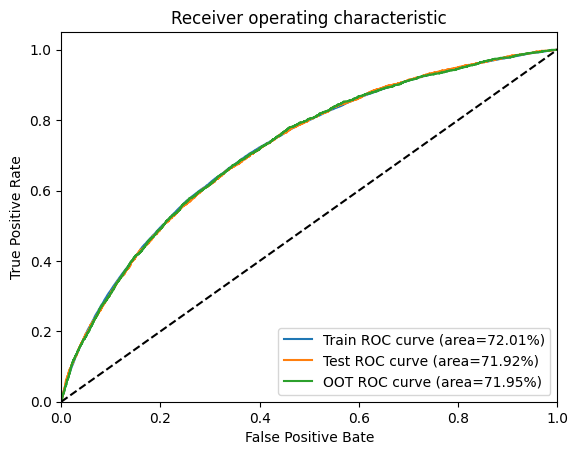

In [ ]:
ROC_curve_combined(y_train,lgr_clf_proba_train[:,1],y_test,lgr_clf_proba_test[:,1],y_oot,lgr_clf_proba_oot[:,1])

### Confusion Matrix

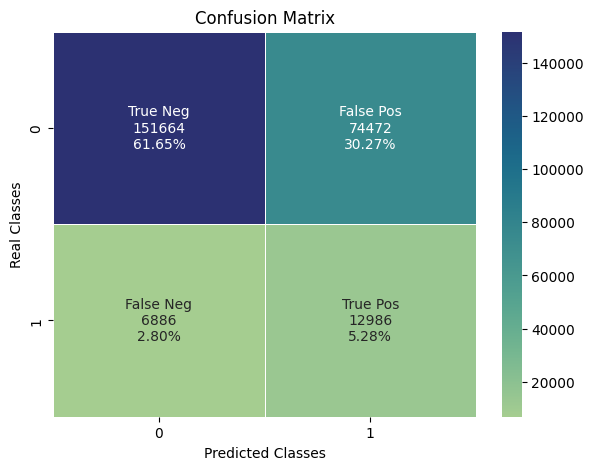

0.6692871776527592
0.148482700267557
0.6534822866344605
0.241982670269263
----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.96      0.67      0.79    226136
           1       0.15      0.65      0.24     19872

    accuracy                           0.67    246008
   macro avg       0.55      0.66      0.52    246008
weighted avg       0.89      0.67      0.74    246008


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.66929
Precision=0.14848
Recall=0.65348
F1 Score=0.24198


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_train,lgr_clf_predict_train)

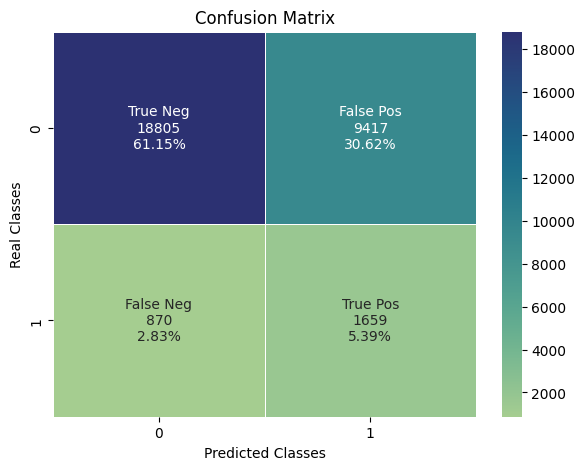

0.66547429351891
0.14978331527627303
0.6559905100830368
0.24388092613009923
----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     28222
           1       0.15      0.66      0.24      2529

    accuracy                           0.67     30751
   macro avg       0.55      0.66      0.51     30751
weighted avg       0.89      0.67      0.74     30751


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.66547
Precision=0.14978
Recall=0.65599
F1 Score=0.24388


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_test,lgr_clf_predict_test)

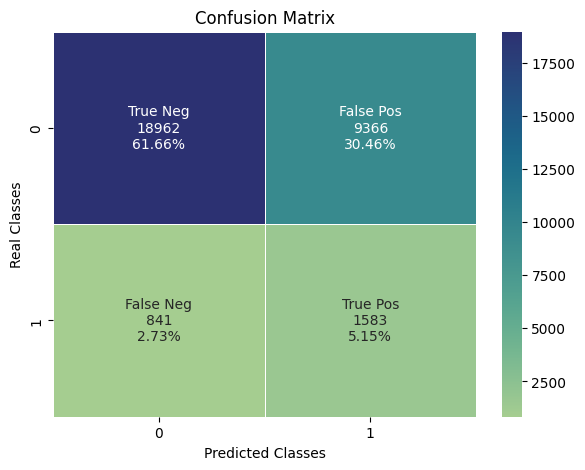

0.6680866285119667
0.14457941364508176
0.653052805280528
0.2367456815972482
----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     28328
           1       0.14      0.65      0.24      2424

    accuracy                           0.67     30752
   macro avg       0.55      0.66      0.51     30752
weighted avg       0.89      0.67      0.74     30752


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.66809
Precision=0.14458
Recall=0.65305
F1 Score=0.23675


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_oot,lgr_clf_predict_oot)

### Decile Table

In [ ]:
decile_tablel(y_train,lgr_clf_proba_train[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.703335,0.999990,24601.0,5587.0,19014.0,19014.0,5587.0,19.706721,2.811471,3.40,3.40,28.11
1,2,0.608646,0.703335,24601.0,3564.0,21037.0,40051.0,9151.0,28.338695,2.302467,5.90,11.24,46.05
2,3,0.535436,0.608645,24601.0,2659.0,21942.0,61993.0,11810.0,32.016320,1.980996,8.25,23.31,59.43
3,4,0.472807,0.535436,24601.0,2074.0,22527.0,84520.0,13884.0,32.491411,1.746665,10.86,40.75,69.87
4,5,0.416918,0.472806,24600.0,1679.0,22921.0,107441.0,15563.0,30.804549,1.566324,13.65,63.99,78.32
5,6,0.363392,0.416917,24601.0,1327.0,23274.0,130715.0,16890.0,27.190250,1.416564,17.54,98.50,84.99
6,7,0.311518,0.363388,24601.0,1080.0,23521.0,154236.0,17970.0,22.223770,1.291836,21.78,142.81,90.43
7,8,0.258647,0.311517,24601.0,793.0,23808.0,178044.0,18763.0,15.686132,1.180237,30.02,224.52,94.42
8,9,0.199377,0.258645,24601.0,626.0,23975.0,202019.0,19389.0,8.234266,1.084101,38.30,322.71,97.57
9,10,0.017453,0.199375,24600.0,483.0,24117.0,226136.0,19872.0,0.000000,1.000000,49.93,468.19,100.00


In [ ]:
decile_tablel(y_test,lgr_clf_proba_test[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.705328,0.998859,3076.0,694.0,2382.0,2382.0,694.0,19.001453,2.743365,3.43,3.43,27.44
1,2,0.611123,0.705319,3075.0,454.0,2621.0,5003.0,1148.0,27.666131,2.269377,5.77,11.02,45.39
2,3,0.539757,0.611013,3075.0,342.0,2733.0,7736.0,1490.0,31.505328,1.963737,7.99,22.62,58.92
3,4,0.475181,0.539752,3075.0,264.0,2811.0,10547.0,1754.0,31.983922,1.733802,10.65,39.95,69.36
4,5,0.417603,0.475179,3075.0,226.0,2849.0,13396.0,1980.0,30.825299,1.565785,12.61,59.27,78.29
5,6,0.363203,0.417592,3075.0,171.0,2904.0,16300.0,2151.0,27.297020,1.417526,16.98,95.32,85.05
6,7,0.310773,0.363199,3075.0,137.0,2938.0,19238.0,2288.0,22.303863,1.292418,21.45,140.42,90.47
7,8,0.257791,0.310742,3075.0,104.0,2971.0,22209.0,2392.0,15.888912,1.182276,28.57,213.55,94.58
8,9,0.197303,0.257742,3075.0,80.0,2995.0,25204.0,2472.0,8.439930,1.086064,37.44,315.05,97.75
9,10,0.015745,0.197259,3075.0,57.0,3018.0,28222.0,2529.0,0.000000,1.000000,52.95,495.12,100.00


In [ ]:
decile_tablel(y_oot,lgr_clf_proba_oot[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.700670,0.987428,3076.0,676.0,2400.0,2400.0,676.0,19.415606,2.788054,3.55,3.55,27.89
1,2,0.607903,0.700639,3075.0,438.0,2637.0,5037.0,1114.0,28.176102,2.297631,6.02,11.50,45.96
2,3,0.535599,0.607891,3075.0,324.0,2751.0,7788.0,1438.0,31.831199,1.977362,8.49,24.04,59.32
3,4,0.473025,0.535566,3075.0,252.0,2823.0,10611.0,1690.0,32.261833,1.742958,11.20,42.11,69.72
4,5,0.418035,0.473015,3075.0,219.0,2856.0,13467.0,1909.0,31.214589,1.575083,13.04,61.49,78.75
5,6,0.364430,0.417964,3076.0,161.0,2915.0,16382.0,2070.0,27.566330,1.423206,18.11,101.75,85.40
6,7,0.311594,0.364408,3075.0,117.0,2958.0,19340.0,2187.0,21.951098,1.288861,25.28,165.30,90.22
7,8,0.257505,0.311592,3075.0,95.0,2980.0,22320.0,2282.0,15.350612,1.176755,31.37,234.95,94.14
8,9,0.198032,0.257493,3075.0,87.0,2988.0,25308.0,2369.0,8.391853,1.085892,34.34,290.90,97.73
9,10,0.016257,0.197956,3075.0,55.0,3020.0,28328.0,2424.0,0.000000,1.000000,54.91,515.05,100.00


### Observations and Conclusion:
1. ROC AUC of 72% is achieved on the OOT data.
2. At 20% of the total transactions this model was able to capture around 46% of total defaulters.

## Predictions on the Kaggle Test dataset:

In [ ]:
# Merged Application test dataframe
pickle_in=open(pickle_path+"application_test_merged.pickle","rb")
application_test_merged=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Application test merged dataframe is",application_test_merged.shape)

Shape of featurized Application test merged dataframe is (48744, 1771)


In [ ]:
# Prediction on the application_test_merged dataframe
lgr_clf_proba_test_oot=lgr_clf.predict_proba(X_test_oot)

In [ ]:
# Preparing the dataframe to be submitted at Kaggle Submission
LGR_sol_kaggle=pd.DataFrame(application_test_merged['SK_ID_CURR'])
LGR_sol_kaggle['TARGET'] = pd.Series(lgr_clf_proba_test_oot[:,1])
LGR_sol_kaggle

,SK_ID_CURR,TARGET
0,100001,0.299428
1,100005,0.495078
2,100013,0.264550
3,100028,0.169173
4,100038,0.652946
...,...,...
48739,456221,0.397521
48740,456222,0.646950
48741,456223,0.286488
48742,456224,0.361692


In [ ]:
# Lets save a dataframe as csv and upload the results on the kaggle submission
LGR_sol_kaggle.to_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/LGR_sol_kaggle.csv',index=False)

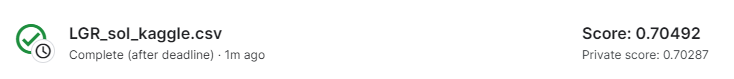

In [ ]:
Image(filename='/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/LogisticRegressionKaggleResult.PNG',width=800,height=100)

### Observations about the kaggle solution submission:
ROC AUC of 70.79% is achieved on the kaggle test data for this model.
